In [ ]:
!pip install groq

In [ ]:
!pip install openai==0.28

In [ ]:
!pip install textstat

In [ ]:
import os
import json
import datetime
import time
import pandas as pd

In [ ]:
# Set up a DataFrame to store results
results = pd.DataFrame(columns=["model", "prompt", "suggestion", "response_time"])

In [ ]:
# Load API keys from config.json
api_key = "API_KEY"
gpt_key = "GPT_KEY"

In [ ]:
# Function to read prompts from the folder
def load_prompts(directory="prompts"):
    prompts = []
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):  # Ensure we are processing only .txt files
            with open(os.path.join(directory, filename), "r") as file:
                content = file.read().strip()
                prompts.append(content)  # Add the content of each file as a separate entry
    return prompts

# all_prompts = load_prompts()
# for idx, prompt in enumerate(all_prompts, start=1):
#     print(f"Prompt {idx}:\n{prompt}\n{'='*40}")

In [ ]:
from groq import Groq

def call_groc_model(model_name, prompt):
  """ Call a Groq model API """
  client = Groq(
      api_key = api_key
  )

  return client.chat.completions.create(
      model=model_name,
      messages=[
          {
              "role": "user",
              "content": "Analyse the code, fix any issues with it and propose solutions to avois boilerplate code by implementing reusable code if possible, return only the code:" + prompt
          }
      ],
      temperature=1,
      max_tokens=1024,
      top_p=1,
      stream=False,
      stop=None,
  )

In [ ]:
import openai

def call_openai_model(model_name, prompt):
    """ Call an OpenAI model API """
    openai.api_key = gpt_key

    response = openai.ChatCompletion.create(
        model=model_name,
        messages=[
            {"role": "system", "content": "You are an AI assistant."},
            {"role": "user", "content": prompt}
        ],
        temperature=0.7,
        max_tokens=1024,
        top_p=1.0,
    )
    return response

In [ ]:
import ast
import re

def extract_code(text):
    """
    Extrait le code entre les symboles ``` et l'affiche.

    Args:
        text (str): Le texte contenant le code à extraire.

    Returns:
        str: Le code extrait ou un message indiquant qu'aucun code n'a été trouvé.
    """
    matches = re.findall(r'```(.*?)```', text, re.DOTALL)
    if matches:
        return matches[0].strip()  # Retourne le premier bloc de code trouvé et le nettoie des espaces
    else:
        return ""

def evaluate_reusability(code_snippet):
    """
    Evaluates the reusability of a code snippet based on modularity, parameterization,
    minimal dependencies, and use of abstraction.
    """
    # Parse code into an Abstract Syntax Tree (AST)
    code_snippet = extract_code(code_snippet)

    if code_snippet == "":
      return

    tree = ast.parse(code_snippet)

    # Initialize metrics for reusability
    num_functions = 0
    parameterized_functions = 0
    modularity_score = 0

    for node in ast.walk(tree):
        # Check for functions and their parameters (modularity and parameterization)
        if isinstance(node, ast.FunctionDef):
            num_functions += 1
            if node.args.args:  # If the function has parameters
                parameterized_functions += 1
            if any(isinstance(n, ast.Return) for n in node.body):
                modularity_score += 1  # Increment modularity for return statements

    # Simple scoring mechanism
    if num_functions == 0:
        return {"reusability_score": 0, "feedback": "Code lacks functions, making it less reusable."}

    param_ratio = parameterized_functions / num_functions
    modularity_ratio = modularity_score / num_functions

    reusability_score = (param_ratio + modularity_ratio) / 2 * 100
    feedback = "Higher parameterization and modularity increase reusability."

    return {"reusability_score": reusability_score, "feedback": feedback}

In [ ]:
import textstat

def benchmark_model(api_name, model_name, prompt, api_type):
  """ Benchmark a certain model """

  # Start time for latency
  start_time = time.time()

  # Call model API
  match api_type:
    case "groq":
      response = call_groc_model(model_name, prompt)
    case "openai":
            response = call_openai_model(model_name, prompt)
    case _:
      print(api_type, "is not an available API type")
      return

  # End timer
  end_time = time.time()
  latency = end_time - start_time

  # Extract response details
  if api_type == "groq":
      tokens_used = response.usage.total_tokens
      generated_text = response.choices[0].message.content
  elif api_type == "openai":
      tokens_used = response["usage"]["total_tokens"]
      generated_text = response["choices"][0]["message"]["content"]

  # Calculate quality metrics (pseudo-code for readability and reusability checks)
  readability_score = textstat.flesch_kincaid_grade(generated_text)
  reusability_score = evaluate_reusability(generated_text)

  # Append to DataFrame directly
  df_metrics.loc[len(df_metrics)] = {
    "api_name": api_name,
    "model_name": model_name,
    "latency": latency,
    "tokens_used": tokens_used,
    "readability_score": readability_score,
    "reusability_score": reusability_score
  }

  timestamp = datetime.datetime.now().strftime("%d%m%Y%H%M%S")
  output_file_name = f"bin/{model_name}_code_{timestamp}.txt"

  with open(output_file_name, 'w') as output_file:
    output_file.write(response.choices[0].message.content)

In [ ]:
# Example usage
# DF for metrics
df_metrics = pd.DataFrame(columns=[
    "api_name", "model_name", "latency", "tokens_used",
    "readability_score", "reusability_score"
])

prompts = load_prompts()

benchmark_model("OpenAI", "gpt-4", prompts[0], "openai")
benchmark_model("llama", "llama3-8b-8192", prompts[0], "groq")
benchmark_model("gemma2", "gemma2-9b-it", prompts[0], "groq")

benchmark_model("OpenAI", "gpt-4", prompts[1], "openai")
benchmark_model("llama", "llama3-8b-8192", prompts[1], "groq")
benchmark_model("gemma2", "gemma2-9b-it", prompts[1], "groq")

benchmark_model("OpenAI", "gpt-4", prompts[2], "openai")
benchmark_model("llama", "llama3-8b-8192", prompts[2], "groq")
benchmark_model("gemma2", "gemma2-9b-it", prompts[2], "groq")

print(df_metrics)

  api_name      model_name    latency  tokens_used  readability_score  \
0   OpenAI           gpt-4   8.285256          316               17.8   
1    llama  llama3-8b-8192   0.519567          457               12.4   
2   gemma2    gemma2-9b-it   0.935015          583               10.4   
3   OpenAI           gpt-4  18.672909          745               27.2   
4    llama  llama3-8b-8192   0.862230          721               14.0   
5   gemma2    gemma2-9b-it   0.919407          753               22.8   
6   OpenAI           gpt-4  17.486771          360                9.2   
7    llama  llama3-8b-8192   0.670716          632               10.2   
8   gemma2    gemma2-9b-it   1.071902          597               10.1   

                                   reusability_score  
0                                               None  
1  {'reusability_score': 100.0, 'feedback': 'High...  
2  {'reusability_score': 50.0, 'feedback': 'Highe...  
3  {'reusability_score': 100.0, 'feedback': 'High

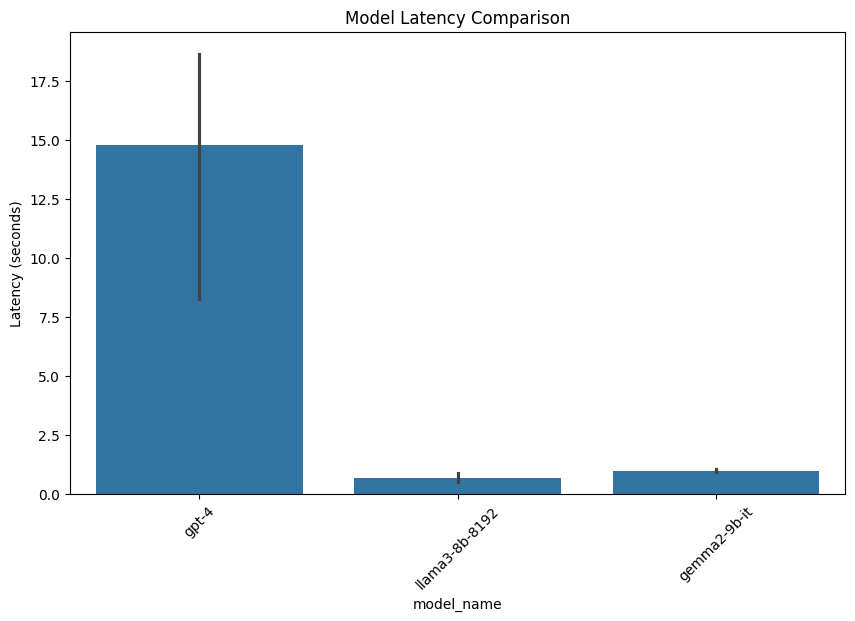

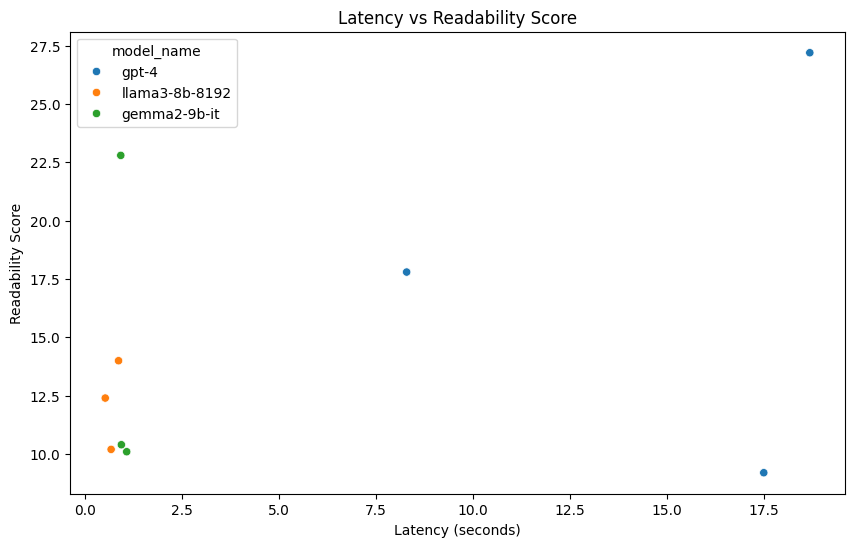

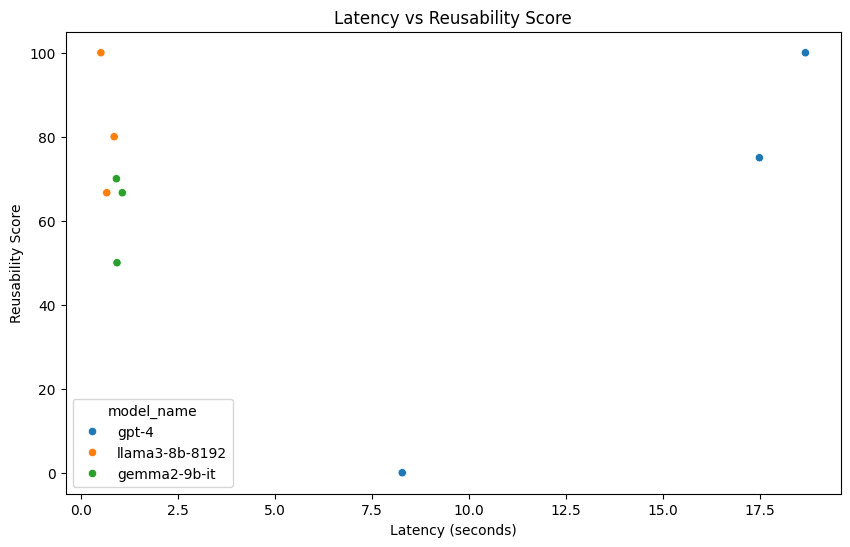

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Bar plot of latency
plt.figure(figsize=(10, 6))
sns.barplot(x='model_name', y='latency', data=df_metrics)
plt.title('Model Latency Comparison')
plt.ylabel('Latency (seconds)')
plt.xticks(rotation=45)
plt.show()

# Scatterplot of latency vs readability
plt.figure(figsize=(10, 6))
sns.scatterplot(x='latency', y='readability_score', hue='model_name', data=df_metrics)
plt.title('Latency vs Readability Score')
plt.xlabel('Latency (seconds)')
plt.ylabel('Readability Score')
plt.show()

# Scatterplot of latency vs readability
plt.figure(figsize=(10, 6))
sns.scatterplot(x='latency', y='reusability_score', hue='model_name', data=df_metrics)
plt.title('Latency vs Reusability Score')
plt.xlabel('Latency (seconds)')
plt.ylabel('Reusability Score')
plt.show()

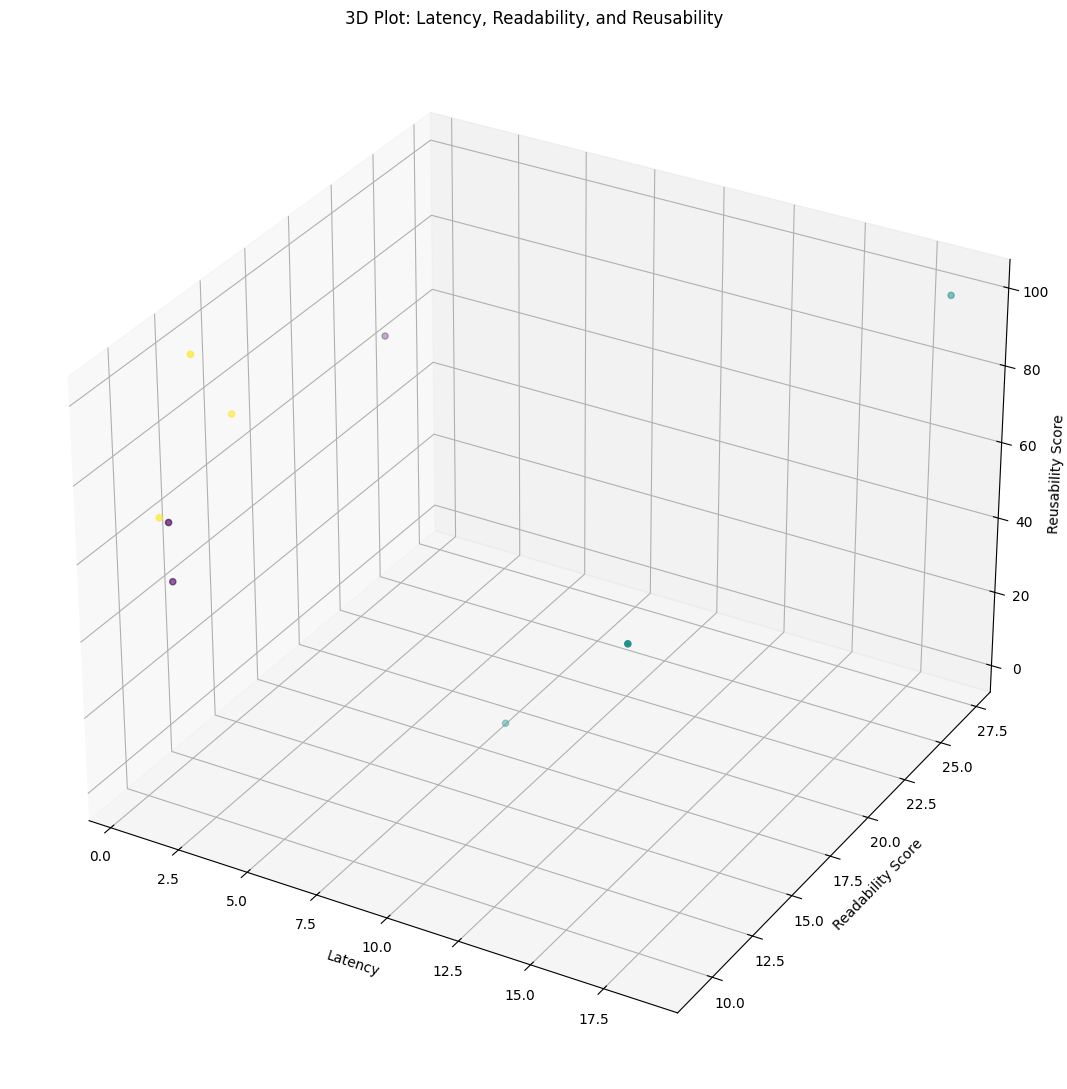

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Ajuster la taille de la figure
fig = plt.figure(figsize=(11, 11))

# Créer le graphique 3D
ax = fig.add_subplot(111, projection='3d')

# Mettre à jour la colonne 'reusability_score' pour extraire les scores
df_metrics['reusability_score'] = df_metrics['reusability_score'].apply(lambda x: x['reusability_score'] if isinstance(x, dict) else 0)

# Tracer le graphique
sc = ax.scatter(df_metrics['latency'], df_metrics['readability_score'], df_metrics['reusability_score'],
                c=df_metrics['model_name'].astype('category').cat.codes)

# Ajouter les étiquettes et le titre
ax.set_xlabel('Latency')
ax.set_ylabel('Readability Score')
ax.set_zlabel('Reusability Score')
plt.title('3D Plot: Latency, Readability, and Reusability')

# Optimiser l'ajustement de la mise en page
plt.tight_layout()

# Afficher le graphique
plt.show()


In [1]:
!jupyter nbconvert --to html benchmarking.ipynb

[NbConvertApp] Converting notebook benchmarking.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 4 image(s).
[NbConvertApp] Writing 688607 bytes to benchmarking.html
